In [1]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import seaborn as sns
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import scipy.sparse as sps

# Load stuff previously defined

In [2]:
import spacy
!pip install --quiet spacymoji
from spacymoji import Emoji
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer.token_match = re.compile("^#\w+$").match
nlp.add_pipe("emoji", first=True)

import emoji
def get_emoji_regexp():
    # Sort emoji by length to make sure multi-character emojis are
    # matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = '(' + '|'.join(re.escape(u) for u in emojis) + ')'
    return re.compile(pattern)

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-4268926626.py:5: SyntaxWarning: invalid escape sequence '\w'
  nlp.tokenizer.token_match = re.compile("^#\w+$").match


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 15.5 MB/s eta 0:00:00


In [28]:
!pip install --quiet igraph
import igraph as ig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 41.3 MB/s eta 0:00:00


In [3]:
class SemanticNetwork:
    def __init__(self,nlp):
        self.nlp=nlp

    def _clean_text_fun(self, text, to_keep=True,
               kr_list = ["ADJ","ADV","EMOJI","HASH","NOUN","PROPN","VERB"]):

        # apply spacy
        doc = self.nlp(" ".join(get_emoji_regexp().split(text)))
        # collect spacy outomes in in a list
        out = list()
        for token in doc:
            out.append((token.text, token.text+token.whitespace_,
                        token.lemma_.lower(), token.pos_,
                        token.text.startswith("#"),
                        token.text.startswith("@"),
                        emoji.purely_emoji(token.text),
                        (token.text.startswith("https:") or token.text.startswith("http:"))
                        ))
        # turn it into a dataframe
        df2 = pd.DataFrame(out)
        df2.columns = ['text', 'full_text', 'lemma', 'PoS',
                      'is_hashtag', 'is_mention', 'is_emoji', 'is_link']
        # build a PoS column that identifies hashtags, mentions, etc
        df2.insert(loc = 4, column = 'myPoS', value = df2['PoS'])
        df2.loc[df2['is_hashtag']==True,'myPoS'] = 'HASH'
        df2.loc[df2['is_mention']==True,'myPoS'] = 'MENT'
        df2.loc[df2['is_emoji']==True,'myPoS'] = 'EMOJI'
        df2.loc[df2['is_link']==True,'myPoS'] = 'HTML'
        # replace emojis lemmas with their description
        for tmp in doc._.emoji:
          df2.loc[tmp[1],'lemma'] = tmp[0]+" "+tmp[2]
        # keep/remove only what is asked
        if to_keep:
          out = [j for (i,j) in zip(df2['myPoS'],df2['lemma']) if i in kr_list]
        else:
          out = [j for (i,j) in zip(df2['myPoS'],df2['lemma']) if i not in kr_list]
        return out

    # with to_keep you can choose if you want to keep or remove certain PoS
    #
    # with kr_list you can choose which POS tags to keep or remove,
    # to be chosen from the following list
    #
    # Universal POS Tags http://universaldependencies.org/u/pos/
    #
    #   "ADJ": "adjective",
    #   "ADP": "adposition",
    #   "ADV": "adverb",
    #   "AUX": "auxiliary",
    #   "CONJ": "conjunction",
    #   "CCONJ": "coordinating conjunction",
    #   "DET": "determiner",
    #   "INTJ": "interjection",
    #   "NOUN": "noun",
    #   "NUM": "numeral",
    #   "PART": "particle",
    #   "PRON": "pronoun",
    #   "PROPN": "proper noun",
    #   "PUNCT": "punctuation",
    #   "SCONJ": "subordinating conjunction",
    #   "SYM": "symbol",
    #   "VERB": "verb",
    #   "X": "other",
    #   "EOL": "end of line",
    #   "SPACE": "space"
    #
    # Internal tags
    #
    #   "EMOJI" emojis,
    #   "HASH" hastags
    #   "HTML" web links,
    #   "MENT" mentions

    def clean_text(self, df, to_keep=True,
               kr_list = ["ADJ","ADV","EMOJI","HASH","NOUN","PROPN","VERB"]):

        self.df = df.copy()
        for i in tqdm(range(len(df))):
          text = df.loc[i,'translated']
          self.df.loc[[i],'clean list'] = pd.Series([
                                    self._clean_text_fun(text, to_keep, kr_list)
                                    ], index=[i])

    # extracts occurrence matrix Nwd, also returns the
    # documents actually in use and the words dictionary
    #
    # words occurring less than n_min times are discarded
    # words occurring more than n_max times are discarded
    #
    # documents with zero active words are discarded

    def get_Nwd(self, n_min=2, n_max=1e10):

        # capture execution time
        tic = time.time()

        # collection of (unique) words
        clean_texts_list = list(self.df['clean list'])
        words = np.unique([item for sublist in clean_texts_list \
                                for item in sublist])
        Nw = len(words) # number of words (so far)
        # documents list
        Nd = len(clean_texts_list) # number of documents (so far)
        documents = np.array(range(Nd))

        # occurrence matrix for words in documents
        words_dict = dict(zip(words,range(Nw))) # words dictionary
        Nwd = csr_matrix((Nw, Nd), dtype = np.int8).toarray()
        for i in range(Nd):
            for j in clean_texts_list[i]:
                Nwd[words_dict[j],i] += 1

        # identify words used less than n_min or more than n_max
        select = ((np.sum(Nwd,axis=1) >= n_min) & \
                  (np.sum(Nwd,axis=1) < n_max))
        # explicitly print the most frequent ones
        print('removing words...')
        with np.printoptions(threshold=np.inf):
          print(words[(np.sum(Nwd,axis=1)>=n_max)])
        # remove them
        Nwd = Nwd[select,:]
        words = words[select]
        # remove documents that do not contain words
        select = (np.sum(Nwd,axis=0)>0)
        Nwd = csr_matrix(Nwd[:,select])
        documents = documents[select]

        # capture execution time
        print(f'Occurrence matrix: execution time {time.time()-tic} [s]')

        self.Nwd = Nwd
        self.words = words
        self.documents = documents

        # plot words occurrences
        plt.figure(figsize=(4, 3))
        plt.semilogy(-np.sort(-np.asarray(np.sum(Nwd,axis=1)).reshape(-1)))
        plt.grid(True)
        plt.xlabel('word id')
        plt.ylabel('# of occurrences')
        plt.title("words occurrencies");
        plt.show()

        # build other matrices
        # equally likely documents case!
        Pwd = Nwd/Nwd.sum(axis=0).flatten()/Nwd.shape[1]
        # words and document matrices
        pd = Pwd.sum(axis=0).flatten()
        Pww = (Pwd/pd).dot(Pwd.T)
        pw = Pwd.sum(axis=1).flatten()
        Pdd = (Pwd.T/pw).dot(Pwd)
        self.Pwd = Pwd
        self.Pdd = Pdd
        self.pd = pd

In [4]:
def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y

# NMI
def nmi_fn(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y

# modularity
def modularity_fn(A):
    y = A.trace()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

# Ncut
def ncut_fn(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

# Infomap - 1
def pagerank_fn(M,q,c=.85,it=60):
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
      r = c*M.dot(r) + (1-c)*q
    return r

# Infomap - 2
def _infomap_fn(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

# Infomap - 3
def infomap_rank_fn(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = pagerank_fn(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T
    return r

# Infomap - 4
def infomap_fn(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = (C.T).dot(sps.diags(r.toarray().flatten()))
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
      tmp = ((C[:,i].transpose()).dot(M)).dot(z[i].transpose())
      q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = _infomap_fn(q)
    for i in range(z.shape[0]):
      y += _infomap_fn(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/_infomap_fn(pd))-1
    return y

# Load data and run BERTopic

In [6]:
# load data
df = pd.read_excel("/content/tweets_greta_translated.xlsx")
df.drop_duplicates(subset=["text"],inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
!pip install --quiet bertopic
from bertopic import BERTopic

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [31]:
# run BERTopic ... it takes about 1 min
topic_model = BERTopic(nr_topics="auto")
docs = df['translated']
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1   1330                         -1_the_to_climatechange_of   
1       0    684                     0_climatechange_to_the_climate   
2       1    314     1_sustainability_plastic_environment_recycling   
3       2    167                          2_sdgs_the_development_to   
4       3    125                 3_food_agriculture_farming_farmers   
5       4     94                          4_ice_arctic_sea_glaciers   
6       5     80                           5_africa_sdgs_in_nigeria   
7       6     69                    6_solar_energy_implement_panels   
8       7     60                    7_trees_forests_planting_forest   
9       8     60                       8_oil_carbon_emissions_spend   
10      9     47                 9_cdnpoli_canadians_canada_trudeau   
11     10     46                         10_electric_cars_norway_ev   
12     11     43             11_water_worldwaterday_the_environment   
13     12     41                     12_sdgs_women_womensday_gender   
14     13     40               13_power_renewables_wind_electricity   
15     14     35          14_auspol_australia_australian_government   
16     15     34             15_cyclone_mozambique_cycloneidai_idai   
17     16     24                 16_insects_insect_numbers_crashing   
18     17     22          17_women_gender_internationalwomensday_to   
19     18     21                      18_ai_iot_robotics_automation   
20     19     21            19_wildlife_species_environment_animals   
21     20     21              20_temperature_record_warmest_records   
22     21     19                   21_airpollution_air_pollution_tb   
23     22     19                          22_mumbai_indian_india_28   
24     23     18                    23_reef_coral_barrier_bleaching   
25     24     17                                24_eu_2050_vote_for   
26     25     17                     25_canada_warming_twice_report   
27     26     17                     26_deal_green_greennewdeal_new   
28     27     17                  27_methane_emissions_fossil_fuels   
29     28     16                     28_fish_lakes_fisheries_oceans   
30     29     15   29_demswork4usa_progressives_healthcare_medicaid   
31     30     15              30_attenborough_david_sir_documentary   
32     31     15          31_cities_city_climate_httpstcotnuyoisan0   
33     32     13                     32_secret_garden_tampa_climate   
34     33     13                      33_ocean_marine_oceans_whales   
35     34     12                 34_fracking_judge_drilling_wyoming   
36     35     12  35_kashthefuturist_cberrl_amazingchevvolt_gezg...   
37     36     12         36_nuclear_energy_httpstcowzwsvj71mq_nukes   
38     37     11                 37_health_immune_population_single   
39     38     11                         38_co2_atmosphere_were_was   

                                       Representation  \
0   [the, to, climatechange, of, and, is, in, on, ...   
1   [climatechange, to, the, climate, and, in, is,...   
2   [sustainability, plastic, environment, recycli...   
3   [sdgs, the, development, to, on, goals, amp, i...   
4   [food, agriculture, farming, farmers, to, soil...   
5   [ice, arctic, sea, glaciers, melting, in, the,...   
6   [africa, sdgs, in, nigeria, for, the, leavenoo...   
7   [solar, energy, implement, panels, lets, solut...   
8   [trees, forests, planting, forest, to, defores...   
9   [oil, carbon, emissions, spend, and, its, lobb...   
10  [cdnpoli, canadians, canada, trudeau, the, pri...   
11  [electric, cars, norway, ev, crisis, air, impl...   
12  [water, worldwaterday, the, environment, waste...   
13  [sdgs, women, womensday, gender, iwd2019, equa...   
14  [power, renewables, wind, electricity, renewab...   
15  [auspol, australia, australian, government, ad...   
16  [cyclone, mozambique, cycloneidai, idai, zimba...   
17  [insects, insect, numbers, crashing, pesticide...   
18  [wome

In [32]:
# reduce outliers (they are very many)
new_topics = topic_model.reduce_outliers(docs, topics)
topic_model.update_topics(docs, topics=new_topics)
topic_model.get_topic_info()

2025-12-14 20:40:52,645 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Topic  Count                                               Name  \
0       0   1343                     0_climatechange_the_to_climate   
1       1    479           1_sustainability_environment_plastic_and   
2       2    273                          2_sdgs_the_development_to   
3       3    143                 3_food_agriculture_farming_farmers   
4       4    104                           4_ice_arctic_sea_melting   
5       5     92                               5_africa_sdgs_in_for   
6       6     96        6_solar_energy_implement_panelsnotpipelines   
7       7     69                    7_trees_forests_planting_forest   
8       8     85                         8_oil_carbon_emissions_gas   
9       9     66                   9_cdnpoli_canada_canadians_price   
10     10     55                      10_electric_cars_norway_tesla   
11     11     63                        11_water_environment_the_of   
12     12     46                     12_sdgs_women_gender_womensday   
13     13     69           13_renewables_power_renewableenergy_wind   
14     14     53        14_auspol_australia_australian_ausvotes2019   
15     15     35             15_cyclone_mozambique_cycloneidai_idai   
16     16     26               16_insects_insect_numbers_pesticides   
17     17     27                         17_women_girls_gender_that   
18     18     31                   18_ai_iot_robotics_ronaldvanloon   
19     19     32                 19_wildlife_nature_species_animals   
20     20     37         20_temperature_phd_kidsbeachgarden_masters   
21     21     38              21_air_pollution_airpollution_smoking   
22     22     20                          22_mumbai_indian_india_28   
23     23     19                    23_reef_coral_barrier_bleaching   
24     24     24                            24_eu_for_european_2050   
25     25     34                     25_warming_canada_global_twice   
26     26     35                     26_green_deal_greennewdeal_new   
27     27     26                    27_methane_emissions_fuels_than   
28     28     17                     28_fish_lakes_fisheries_oceans   
29     29     18   29_demswork4usa_progressives_healthcare_medicaid   
30     30     20              30_attenborough_david_sir_documentary   
31     31     28                      31_cities_city_climate_change   
32     32     21                      32_garden_climate_back_secret   
33     33     27                         33_ocean_oceans_marine_amp   
34     34     15                   34_fracking_judge_drilling_court   
35     35     14  35_kashthefuturist_jackthelad1947_charluv2011_...   
36     36     18                36_nuclear_energy_policy_greenpeace   
37     37     23                        37_health_problem_is_immune   
38     38     26                     38_co2_were_atmosphere_million   

                                       Representation  \
0   [climatechange, the, to, climate, of, is, and,...   
1   [sustainability, environment, plastic, and, fo...   
2   [sdgs, the, development, to, amp, on, for, of,...   
3   [food, agriculture, farming, farmers, soil, to...   
4   [ice, arctic, sea, melting, glaciers, in, the,...   
5   [africa, sdgs, in, for, nigeria, of, the, amp,...   
6   [solar, energy, implement, panelsnotpipelines,...   
7   [trees, forests, planting, forest, deforestati...   
8   [oil, carbon, emissions, gas, and, its, climat...   
9   [cdnpoli, canada, canadians, price, trudeau, t...   
10  [electric, cars, norway, tesla, ev, energy, cr...   
11  [water, environment, the, of, amp, is, and, wo...   
12  [sdgs, women, gender, womensday, iwd2019, girl...   
13  [renewables, power, renewableenergy, wind, ene...   
14  [auspol, australia, australian, ausvotes2019, ...   
15  [cyclone, mozambique, cycloneidai, idai, zimba...   
16  [insects, insect, numbers, pesticides, crashin...   
17  [women, girls, gender, that, to, international...   
18  [ai, iot, robotics, ronaldvanloon, automation,...   
19  [wildlife, nature, 

In [33]:
topic_model.visualize_topics()

In [34]:
topic_model.visualize_heatmap()

In [35]:
topic_model.visualize_documents(docs)

In [36]:
topic_model.visualize_barchart(top_n_topics=100, n_words=15)

# Get measures on topic assignment

In [18]:
# load stored data
with open("/content/semantic_net.pkl", 'rb') as f:
    in_data = pickle.load(f)

/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.



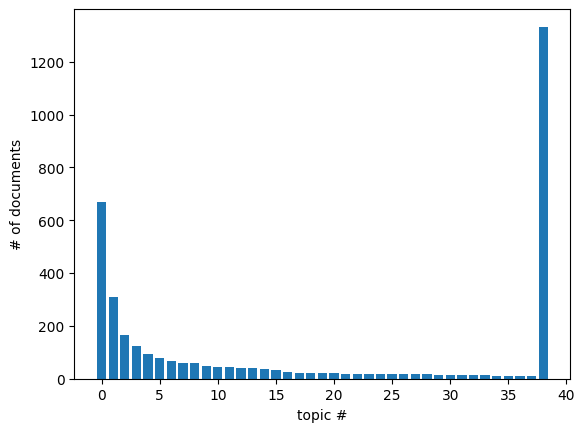

In [40]:
# build C matrix
b_topics = np.array(new_topics)
b_topics = b_topics[in_data.documents]
C = sps.csr_matrix((len(b_topics),b_topics.max()+1))
for i in range(len(b_topics)):
  C[i,b_topics[i]] = 1

# builds topic matrices
Pwc = in_data.Pwd.dot(C) # joint word + class probability
Pcc = ((C.T).dot(in_data.Pdd)).dot(C) # joint class + class probability
pc = Pcc.sum(axis=0)

# show number of topics, and size
plt.bar(np.array(range(C.shape[1])),np.array(C.sum(axis=0))[0])
plt.xlabel("topic #")
plt.ylabel("# of documents");

In [41]:
# extract measures
NMI = nmi_fn(Pwc)
Q = modularity_fn(Pcc)
Ncut = ncut_fn(Pcc)
rd = infomap_rank_fn(in_data.Pdd) # we need the PageRank vector first
Infomap = infomap_fn(C,in_data.Pdd,rd)
if (pc.shape[1]==1):
    com = 0
else:
    com = _infomap_fn(pc)/np.log(pc.shape[1])

In [42]:
# collect them in dataframe
pd.DataFrame(data = {'topics': C.shape[1], 'com': com,
                     'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}, index=[0])

topics       com      NMI         Q      Ncut   Infomap
0      39  0.664808  0.29315  0.096722  0.857763  0.085053